In this notebook we create an effective PSF at which to model galaxy morphologies,
and we use an isotropic Hanning window for that purpose

In [15]:
%pylab inline
import galsim
from scipy.signal.windows import hann
from galsim.bounds import _BoundsI

Populating the interactive namespace from numpy and matplotlib


In [185]:
stamp_size=501
pixel_scale=0.03
k_scale=2. * np.pi / (pixel_scale * stamp_size)
target_pixel_scale=0.168

In [186]:
# Hann window
my_psf = np.zeros((stamp_size,stamp_size))
for  i in range(stamp_size):
    for j in range(stamp_size):
        r = sqrt((i - 1.0*stamp_size//2)**2 + (j-1.0*stamp_size//2)**2)/(stamp_size//2)*pi/2*target_pixel_scale/pixel_scale
        my_psf[i,j] = sin(r+pi/2)**2
        if r > pi/2:
            my_psf[i,j] = 0 
# Building the corresponding galsim image
effective_psf = galsim.InterpolatedKImage(galsim.ImageCD(my_psf+0j, scale=k_scale))

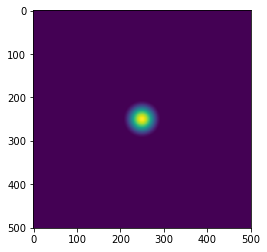

In [189]:
imshow(my_psf);

In [190]:
from astropy.io import fits
# Exporting the effective PSF
fits.writeto('../data/hsc_hann_window.fits', my_psf, clobber=True)

In [191]:
data_dir='/usr/local/share/galsim/COSMOS_25.2_training_sample'
stamp_size=64
pixel_scale=0.168
k_scale=2. * np.pi / (pixel_scale * stamp_size)

cat = galsim.COSMOSCatalog(dir=data_dir)

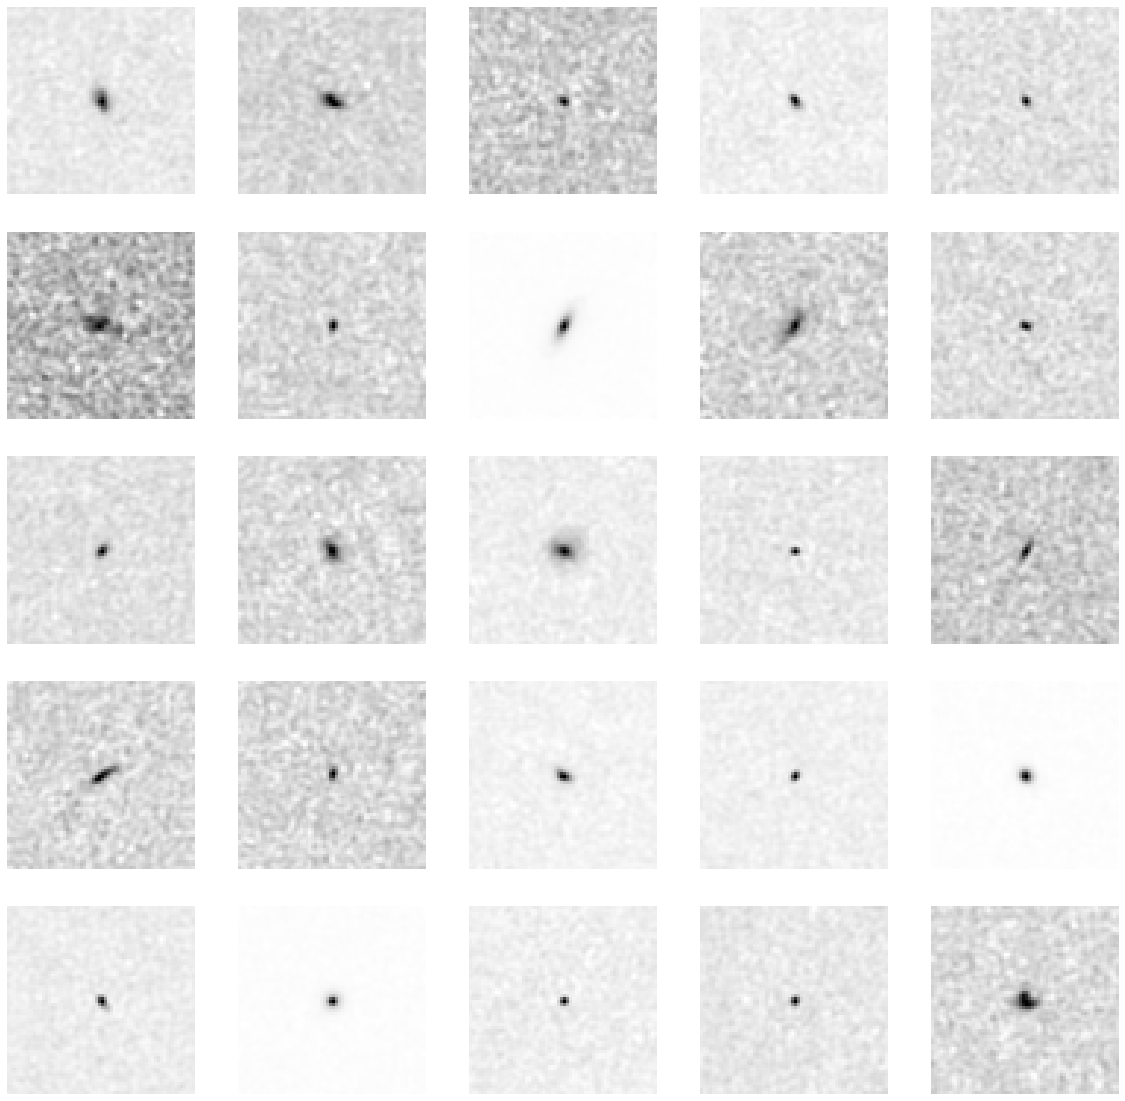

In [192]:
im = galsim.Image(stamp_size, stamp_size, scale=pixel_scale)

figure(figsize=(20,20))
c = 0
for i in range(2,27):
    gal = cat.makeGalaxy(i, noise_pad_size=64 * 0.168)
    gal = galsim.Convolve(gal, effective_psf)
    
    imC = galsim.ImageCF(stamp_size, stamp_size, scale=2. *
                         np.pi / (pixel_scale * stamp_size))
    gal.drawKImage(image=imC)
    im = np.fft.fftshift(np.fft.ifft2(
         np.fft.fftshift(imC.array))).real.astype('float32')
    
    subplot(5,5,c+1)
    imshow(im,cmap='gray_r')
    axis('off')
    c+=1

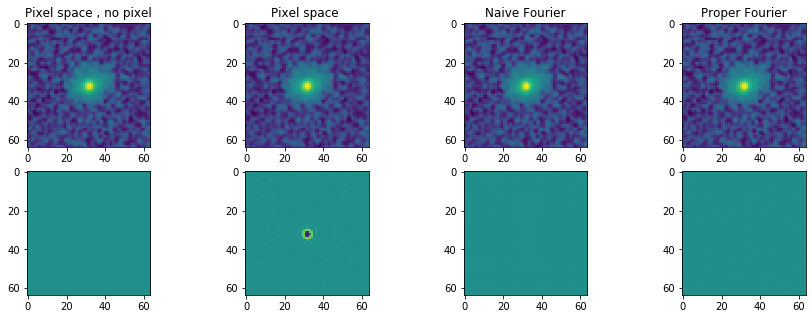

In [193]:
from galsim.bounds import _BoundsI

figure(figsize=(15,5))
stamp_size=64
pixel_scale=0.168

psf = effective_psf.withFlux(1.0)

im = galsim.Image(stamp_size, stamp_size, scale=pixel_scale)

imC = galsim.ImageCF(scale=2. * np.pi / (2*pixel_scale * stamp_size), 
                     bounds=_BoundsI(0, 2*stamp_size//2, -2*stamp_size//2, 2*stamp_size//2-1))

gal  = cat.makeGalaxy(46, noise_pad_size=2*stamp_size * pixel_scale)

subplot(241)
galsim.Convolve(gal, psf).drawImage(im, method='no_pixel', use_true_center=False);
imshow(arcsinh(50*im.array))
imref=im.array*1.0
title('Pixel space , no pixel')

subplot(242)
galsim.Convolve(gal, psf).drawImage(im, use_true_center=False);
imshow(arcsinh(50*im.array))
title('Pixel space ')

subplot(243)
g = galsim.Convolve(gal, psf)#, real_space=False)
g.drawKImage(image=imC, recenter=False)
imr = np.fft.fftshift(np.fft.irfft2(np.fft.fftshift(imC.array, axes=0))).astype('float32')[32:-32,32:-32]

imshow(arcsinh(50*imr))
title('Naive Fourier')

subplot(244)
g = galsim.Convolve(gal, psf)
kim, N = g.drawFFT_makeKImage(image=im)

# Draw image
g._drawKImage(kim)

bwrap = _BoundsI(0, N//2, -N//2, N//2-1)
kimage_wrap = kim._wrap(bwrap, True, False)

imshow(arcsinh(50*fftshift(irfft2(fftshift(kimage_wrap.array, axes=0))))[32:-32,32:-32]); 
title('Proper Fourier')

subplot(245)
galsim.Convolve(gal, psf).drawImage(im, method='no_pixel', use_true_center=False);
imshow(arcsinh(50*(im.array -imref)),vmax=5,vmin=-5)

subplot(246)
galsim.Convolve(gal, psf).drawImage(im, use_true_center=False);
imshow(arcsinh(50*(im.array - imref)),vmax=5,vmin=-5); 

subplot(247)
g = galsim.Convolve(gal, psf)#, real_space=False)
g.drawKImage(image=imC, recenter=False)
imr = np.fft.fftshift(np.fft.irfft2(np.fft.fftshift(imC.array, axes=0))).astype('float32')[32:-32,32:-32]

imshow(arcsinh(50*(imr- imref)),vmax=5,vmin=-5);

subplot(248)
g = galsim.Convolve(gal, psf)
kim, N = g.drawFFT_makeKImage(image=im)

# Draw image
g._drawKImage(kim)

bwrap = _BoundsI(0, N//2, -N//2, N//2-1)
kimage_wrap = kim._wrap(bwrap, True, False)

imshow(arcsinh(50*(fftshift(irfft2(fftshift(kimage_wrap.array, axes=0)))[32:-32, 32:-32] - imref)),vmax=5,vmin=-5)